In [85]:
#default:     sigma_1 = 1 v= 0.1  c1= 0.1 a=0.2 alpha=0.05
def model_spec():
    sigma_1 = 1
    v= 0.01
    c1= 0.1
    a=0.2
    alpha=0.05
    return(sigma_1,v,c1,a,alpha)
variables = model_spec()

In [86]:
variables

(1, 0.01, 0.1, 0.2, 0.05)

array([[ 0.        ,  0.14142136, 12.72792206, 14.14213562, 33.24154028],
       [ 0.14142136,  0.        , 12.58650071, 14.00071427, 33.10015106],
       [12.72792206, 12.58650071,  0.        ,  1.41421356, 20.51828453],
       [14.14213562, 14.00071427,  1.41421356,  0.        , 19.10497317],
       [33.24154028, 33.10015106, 20.51828453, 19.10497317,  0.        ]])

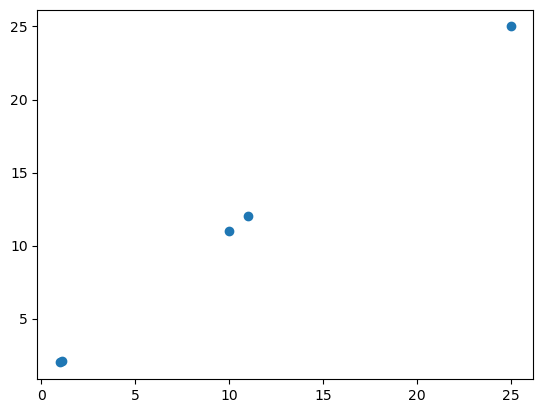

In [87]:
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt

def model_distance(n):
    x= [1,1.1,10,11,25]
    y= [2,2.1,11,12,25]
    np.random.seed(10)
    #x = []
    #y=[]
    #for i in range(n):
        #x.append(np.random.randint(0,50))
        #y.append(np.random.randint(0,50))
    mover = zip(x,y)
    mover = list(mover)
    #mover = [(1,2),(2,3),(10,11),(11,12),(25,25)]
    plt.plot(x,y,'o')
    
    C = np.zeros((len(mover),len(mover)))
    for i in range(len(mover)):
        for j in range(len(mover)):
                C[i][j]= sqrt(((mover[i][0] - mover[j][0])**2 + (mover[i][1] - mover[j][1])**2))
    return(C)
 
C=model_distance(5)
C

In [109]:
#monte carlo simulation considering Xi(t) = N(0,cov_matrix) in the probabilty
#when the locations are **very** far from each other
from scipy import special
import time

start_time = time.time()

n=5
t=1000

sumofmovers = 0
number_of_movers_occurance = 0
corr_count =0
uncorr_count =0
E_x1=0
E_x2=0
E_x5=0
eps = 0.001

repeat = 1
for count in range(repeat):
    number_of_movers_occurance = number_of_movers_occurance + 1
    D = np.zeros((n,n))
    for i in range(0,n):
        D[i][i] = sum(C[i])
    S_inverse = (1/variables[1]**2)*(D-C)
    #produce the general inverse matrix
    S = np.linalg.pinv(S_inverse)
    mean = np.zeros(n)
    b0 = np.random.multivariate_normal(mean,S)
    b1 = np.random.multivariate_normal(mean,S)
    
    #let's consider x(t) now
    #spatial cov matrix

    sp_cov_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if C[i][j] == 0:
                sp_cov_matrix[i][j] = ((1-variables[1])*(np.exp(-variables[2]*C[i][j])) +variables[1]*1)
            else:
                sp_cov_matrix[i][j] = ((1-variables[1])*(np.exp(-variables[2]*C[i][j])))
    #temporal cov matrix
    tp__cov_matrix = np.zeros((t,t))
    for k in range(0,t):
        for i in range(0,t):
            #unit is one hour, assume that resolution of data is 5 min
              tp__cov_matrix[k][i]=  ((1+variables[3]*(np.abs(k-i)/12)**(2*variables[4]))**(-1))     
                
    #final spatio-temporal covariance matrix
    cov_matrix = np.zeros((t*n,t*n))
    for k in range(0,t):
        for q in range(0,t):
            for i in range(n):
                for j in range(n):
                    cov_matrix[k*n+i][q*n+j] = sp_cov_matrix[i][j]*tp__cov_matrix[k][q]
    mean_1 = np.zeros(n*t)
    x= np.random.multivariate_normal(mean_1,cov_matrix)
    x= x[::-1]
    
    #finally, states

    # make a matrix for movers, with the size of time steps 
    #considering the initial states
    y_=np.zeros((t,n))

    #choose the initial state randomly
    for i in range(n):
        y_[0][i]= round(np.random.random())

    #choose the next state, based on the transition probabilities
    prob_01 = np.zeros((n,t))
    prob_10 = np.zeros((n,t))
    
    for i in range(0,n*t):
        for j in range(0,n):
            if (i)%n == j:
                prob_01[j][int((i)/n)] = eps*b0[j]+ 5.7*x[i]
                prob_10[j][int((i)/n)] = eps*b1[j]+ 5.7*x[i]

    for i in range (0,n):
        for j in range(0,t):
            prob_01[i][j] = special.expit (prob_01[i][j])
            prob_10[i][j] = special.expit (prob_10[i][j])

            if y_[j-1][i]==0:
                if np.random.random() <= prob_01[i][j]:
                    y_[j][i]=1
                else:
                    y_[j][i]=0

            elif y_[j-1][i]==1:
                if np.random.random() <= prob_10[i][j]:
                    y_[j][i]=0
                else:
                    y_[j][i]=1
    yohoo = 0 
 
    for i in range (0,t):
        counter = 0
        for k in range (0, n):
            if y_[i][k] ==1:
                counter = counter+1
        if counter == n:
            yohoo = yohoo+1
    sumofmovers = sumofmovers+yohoo
    for j in range (0,t):
        if y_[j][3] == y_[j][4] == 1:
            corr_count = corr_count+1
        if y_[j][0] == y_[j][4] == 1:
            uncorr_count = uncorr_count+1      
    E_x1=sum(y_[:][:])[4]+E_x1
    E_x2=sum(y_[:][:])[3]+E_x2
    E_x5=sum(y_[:][:])[0]+E_x5

print("p[x1]",E_x1/(repeat*t))
print("p[x2]",E_x2/(repeat*t))
print("p[x5]",E_x5/(repeat*t))

corr_corr = ((corr_count/(repeat*t)) - (E_x1/(repeat*t))*(E_x2/(repeat*t))) /sqrt(((E_x1/(repeat*t)) - (E_x1/(repeat*t))**2)*((E_x2/(repeat*t)) -(E_x2/(repeat*t))**2))
corr_uncorr = ((uncorr_count/(repeat*t)) - (E_x1/(repeat*t))*(E_x5/(repeat*t))) /sqrt(((E_x1/(repeat*t)) - (E_x1/(repeat*t))**2)*((E_x5/(repeat*t)) -(E_x5/(repeat*t))**2))
#corr
print('total numbers of times all of them are in state 1:',sumofmovers)
print('Expected number of times that all of them are= 1:',sumofmovers/(repeat))
print("times both of the correlated ones are =1:",corr_count)
print("times both of the uncorrelated ones are =1:",uncorr_count)

print("corr of the correlated ones are =1:",corr_corr)
print("corr of the uncorrelated ones are =1:",corr_uncorr)

end_time = time.time()
total_time = end_time-start_time


p[x1] 0.498
p[x2] 0.506
p[x5] 0.503
total numbers of times all of them are in state 1: 33
Expected number of times that all of them are= 1: 33.0
times both of the correlated ones are =1: 231
times both of the uncorrelated ones are =1: 190
corr of the correlated ones are =1: -0.08395871686931067
corr of the uncorrelated ones are =1: -0.24198229155167975


In [110]:
y_

array([[1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1.]])

corrolation between 2 individuals:
**Grouped:**
v = 0.001
times the correlated ones are =one 5968
times the q uncorrelated ones are =one 5877

v= 0.1
times the correlated ones are =one 6000
times the q uncorrelated ones are =one 5920

v= 0.8
p[x1] 0.49575
p[x2] 0.5002083333333334
p[x5] 0.49604166666666666
total numbers of times all of them are in state 1: 739
Expected number of times that all of them are= 1: 0.739
times both of the correlated ones are =1: 6008
times both of the uncorrelated ones are =1: 5879
times both of the correlated ones are =1: 0.009420549474556844
times both of the uncorrelated ones are =1: -0.00381754920547263



**All close to each other:**
**All far fro each other:**

**Grouped**\
repetitions: 1000 \
default variables: v= 0.1  $c_1$= 0.1   a=0.2  alpha=0.05

| Variable that changed | # all of them are in state 1 | # closest ones are=1  | corr of closest ones |# far ones are=1  | corr of far ones |
| --- | --- | --- | ---| ---| ---|
| v = 0.1 | 730 | 6008 | 0.0112|5858 |-0.0041
| v = 0.8 | 739 | 5861 | 0.0094|5879 |-0.0038
| v = 0.001 | 723 | 5958 | 0.0190|5819 |0.0017
| a= 100 |768 |6036| 0.0089 |5949|-0.0074
| a = 0.01 | 741 | 5895|0.0071|5851 | -0.0050
|alpha = 1 | 758 | 5971 | 0.0015|5921|-0.0038
|alpha =0.001 |765| 5981|0.0045|5916|0.0025

In [7]:
y_

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1.]])

In [89]:
x_5 = []
for i in range(len(x)):
    if i%5 ==0:
        x_5.append(x[i])
x_5

[-0.022829330090422983,
 -0.06047928795158435,
 0.33236605634960337,
 0.49616077990192736,
 0.3347117097401688,
 1.0068818702533597,
 0.6802676337870639,
 0.8765179805277235,
 -0.0639282911431773,
 0.6443620044476552,
 0.6578182458776911,
 0.5289111023015897,
 0.45289635891181956,
 0.5489858378425118,
 1.3309961236769177,
 0.05556039158083826,
 0.7384295772457672,
 -0.11328957429600307,
 0.4048472922641691,
 0.8654808777703104,
 0.6941196766005997,
 0.3698441803347653,
 0.7213299048146707,
 0.4182709010400148]

In [90]:
x_4 = []
for i in range(len(x)):
    if i%5 ==1:
        x_4.append(x[i])
x_4

[0.3341963211777106,
 0.587854942188025,
 -0.0004587216008528258,
 0.16896909074113356,
 0.19872975203985394,
 0.297831534512518,
 0.7089032313384458,
 -0.0022580222727394818,
 0.34863293270993645,
 -0.15352821187211188,
 0.23839675493126997,
 -0.36521773224528037,
 0.7179920219650902,
 0.7364767092338513,
 -0.019992338058708547,
 -0.15506866132347477,
 -0.23859626860437824,
 -0.033124318434976145,
 -0.48818299116921043,
 -0.5841145690507886,
 0.20768628130681718,
 -0.2701880684257391,
 0.16449622668061054,
 0.12271880695484784]

In [91]:
x_3 = []
for i in range(len(x)):
    if i%5 ==2:
        x_3.append(x[i])
x_3

[0.49669824445565186,
 0.7718497002253855,
 0.38615890112135476,
 0.1530321392200733,
 0.5874416716554951,
 0.7350709087229457,
 1.2709297977529805,
 0.10127974527202907,
 0.7594192655843849,
 0.26074758921482993,
 0.6062714563989806,
 0.2369840792290934,
 1.077975300709824,
 1.3463995309952461,
 0.7098566930669743,
 0.22400504385772851,
 0.5745325135211442,
 0.5424845005184499,
 -0.05354380625663651,
 -0.28502886354674994,
 0.6920917360612602,
 -0.10805697365714935,
 0.3930257810868908,
 0.20289417879865462]

In [92]:
x_2 = []
for i in range(len(x)):
    if i%5 ==3:
        x_2.append(x[i])
x_2

[-0.32615875986034487,
 -0.6316472496162866,
 -0.037134612076459295,
 0.1429841577832526,
 0.49013748986646527,
 -0.06336316241844463,
 0.5431087458171682,
 -0.16450490519175168,
 -0.16986809803107433,
 0.23625923491073172,
 -0.49762097390079907,
 -0.4127728242641381,
 0.01552988371591694,
 -0.06033996731290843,
 0.24650249672520735,
 -0.9665017309964805,
 -1.129536868182323,
 0.06306407897155271,
 -0.29322340789046186,
 -0.18746360343626361,
 0.4717234207778382,
 0.1541794424669628,
 0.029590431401390643,
 0.5118737869716368]

In [93]:
x_1 = []
for i in range(len(x)):
    if i%5 ==4:
        x_1.append(x[i])
x_1

[-0.41808763064495863,
 -0.8442142039631418,
 -0.14487256490748587,
 0.10013943714723353,
 0.40038252028835297,
 -0.07597698029836132,
 0.576860278420949,
 -0.24545234463306193,
 -0.3547058099396071,
 0.2343181342946508,
 -0.5110470522192982,
 -0.31711990319862793,
 -0.13111247183331332,
 -0.12624774424577329,
 0.15524201515499433,
 -0.9572109061550065,
 -1.20738823552009,
 0.052752660616682635,
 -0.2950444927815906,
 -0.1596170100147669,
 0.2507871076790554,
 0.2048716057783812,
 0.09428462500090631,
 0.5406752012705581]

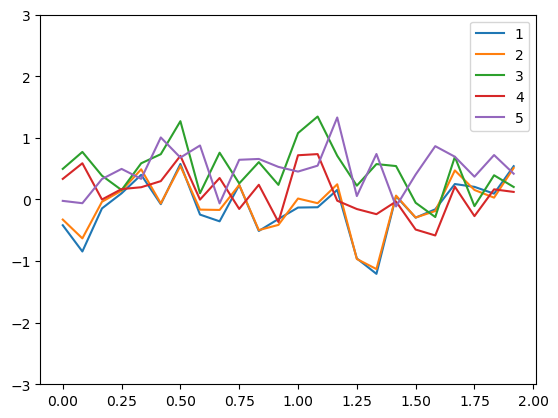

In [94]:
Time =np.arange(0, 24, 1, dtype=int)
Time = Time* (1/12)
plt.ylim([-3, 3])
plt.plot(Time,x_1, label='1')
plt.plot(Time,x_2, label='2')
plt.plot(Time,x_3, label='3')
plt.plot(Time,x_4,label='4')
plt.plot(Time,x_5,label='5')
plt.legend()


In [221]:
y_

array([[0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 1.]])

In [6]:
sumofmovers

73

5 samples:
location : (0,5)    sumofmovers/(repeat)=0.6801
location : (0,50)   sumofmovers/(repeat)=0.6631

Grouped: 2/2/1      print(sumofmovers/(repeat)) = 0.6783

2 samples
location : (0,2) corr: 0.011414832570969652
location : (0,20) corr: 0.010548184940579514
location : (0,200) corr: 0.0010274434411589426